In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from elephant import kernels
from elephant import statistics
import quantities as pq
from quantities import s
import os
import neo
from dPCA import dPCA
from numpy.random import rand, randn, randint

## **Preprocessing: PSTH computation**

In [34]:
data_path="data3/"

neurons_p_values=pd.read_pickle('/Users/machraouianas/Desktop/MPI TU/p_values_pickle.pickle')
neurons_p_values["187"]=0

experiment3_files = [f for f in os.listdir(data_path) if (("t3" in f) or ("t1" in f))]

#generate an empty spike train to be used later for empty rate initialization
spiketrain0 = neo.SpikeTrain([0]*s, t_start=0,t_stop=7, units='s')
kernel = kernels.GaussianKernel(sigma=50 * pq.ms)

trial_df=[]
for filename in experiment3_files:
  
  #loading each tuple
  df=pd.read_csv(os.path.join(data_path+filename))
  
  if (not df.empty):
    #trial counter init
    trial_number=0
    
    #generate zero rate
    rate=np.zeros([7000,1])*pq.Hz
    
    for i in range(len(df)):
      #considering one trial at a time, converting data to suitable format for preprocessing using elephant
      
      df1=df.iloc[i,:]
      df1=df1.reset_index(drop=True)
      df1.index=df1.index*0.002
      df1=df1[df1==1]
      
      if (not df1.empty):
        #calculating PSTH for each trial
        trial_number+=1
        spiketrain = neo.SpikeTrain(df1.index*s, t_start=0,t_stop=7, units='s')
        rate += statistics.instantaneous_rate(spiketrain,sampling_period=1 * pq.ms,kernel=kernel)
  rate/=trial_number
  trial_df.append(trial_number)
  #Center data
  
  rate_mean=np.mean(rate)
  rate-=rate_mean
  
  np.save(os.path.join('data3/psth_raw',filename[:-4]),rate)
  if (neurons_p_values[filename.split("t")[0][1:]]>0.1):
    np.save(os.path.join('data3/psth_filtered',filename[:-4]),rate)

## PSTH per Neuron

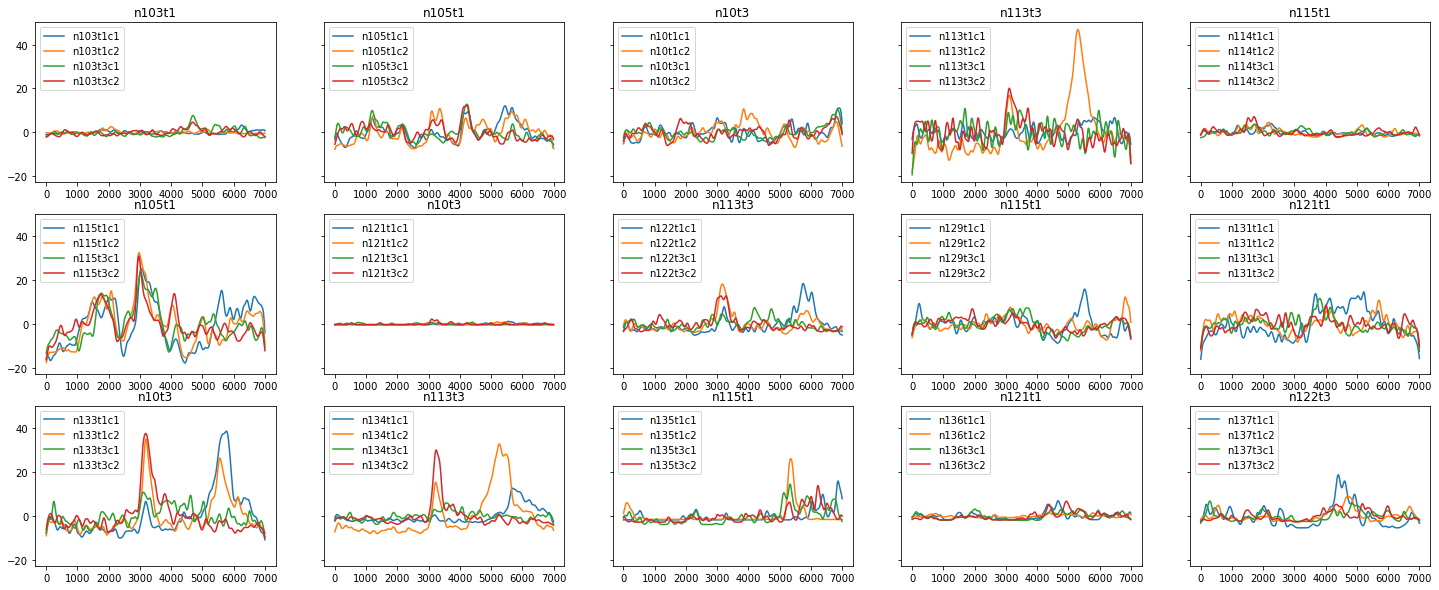

In [53]:
psth_path='/Users/machraouianas/Desktop/MPI TU/code/data3/psth_filtered/'
psth_files = [f[:-6] for f in sorted(np.unique(os.listdir(psth_path)))]

# Create two subplots and unpack the output array immediately
f, axs = plt.subplots(3, 5, sharey=True,figsize=(25,10))

counter=0
for i in range(len(axs)):
  for j in range(len(axs[0])):
    
    axs[i][j].plot(np.load(psth_path+psth_files[counter]+"c1.npy"),label=psth_files[counter]+"c1")
    axs[i][j].legend(loc='upper left')
    axs[i][j].plot(np.load(psth_path+psth_files[counter+1]+"c2.npy"),label=psth_files[counter+1]+"c2")
    axs[i][j].legend(loc='upper left')
    axs[i][j].set_title(psth_files[i*5+j])
    
    axs[i][j].plot(np.load(psth_path+psth_files[counter+2]+"c1.npy"),label=psth_files[counter+2]+"c1")
    axs[i][j].legend(loc='upper left')
    axs[i][j].plot(np.load(psth_path+psth_files[counter+3]+"c2.npy"),label=psth_files[counter+3]+"c2")
    axs[i][j].legend(loc='upper left')
    axs[i][j].set_title(psth_files[i*5+j*5])
    counter+=4
plt.show()


## Constructing big matrices X and X_filtered

In [80]:
psth_path_raw="/Users/machraouianas/Desktop/MPI TU/code/data3/psth_raw/"
psth_path_f="/Users/machraouianas/Desktop/MPI TU/code/data3/psth_filtered/"

psth_raw = [f[:-6] for f in sorted(np.unique(os.listdir(psth_path_raw)))]
psth_filtered = [f[:-6] for f in sorted(np.unique(os.listdir(psth_path_f)))]

In [87]:
#constructing the big matrix X
X=np.zeros((int(len(psth_raw)/4),2,2, 7000))
X_filtered=np.zeros(( int(len(psth_filtered)/4),2,2, 7000))

counter=0
for f in range(len(X)):
  x1=np.load(psth_path_raw+psth_raw[counter]+"c1.npy").reshape(7000)
  x2=np.load(psth_path_raw+psth_raw[counter+1]+"c2.npy").reshape(7000)
  x3=np.load(psth_path_raw+psth_raw[counter+2]+"c1.npy").reshape(7000)
  x4=np.load(psth_path_raw+psth_raw[counter+3]+"c2.npy").reshape(7000)
  
  X[f][0,0]+=x1
  X[f][0,1]+=x2
  X[f][1,0]+=x3
  X[f][1,1]+=x4
  counter+=4

counter=0
for f in range(len(X_filtered)):
  x1_f=np.load(psth_path_f+psth_filtered[counter]+"c1.npy").reshape(7000)
  x2_f=np.load(psth_path_f+psth_filtered[counter+1]+"c2.npy").reshape(7000)
  x3_f=np.load(psth_path_f+psth_filtered[counter+2]+"c1.npy").reshape(7000)
  x4_f=np.load(psth_path_f+psth_filtered[counter+3]+"c2.npy").reshape(7000)
  
  X_filtered[f][0,0]+=x1_f
  X_filtered[f][0,1]+=x2_f
  X_filtered[f][1,0]+=x3_f
  X_filtered[f][1,1]+=x4_f

  counter+=4
  

#  I dPCA plots


In [98]:
dpca = dPCA.dPCA(labels='sct')
dpca_f= dPCA.dPCA(labels='sct')

In [99]:
Z = dpca.fit_transform(X)
Z_f=dpca_f.fit_transform(X_filtered)

In [117]:
def plot_dpca(Z):
 time = np.arange(7000)

 # Create two subplots and unpack the output array immediately
 f, axs = plt.subplots(4, 5, sharey=True,figsize=(25,40))

 plot_dictionary={0:['t','Time'],1:['st','Task'],2:['ct','Stimulus'],3:['sct','Interaction']}

 for j in range(len(axs[0])):
     for i in plot_dictionary:
        
         axs[i][j].plot(time,Z[plot_dictionary[i][0]][j][0,0],"b",label="Perform: Lift")
         axs[i][j].legend(loc='upper left')
         axs[i][j].plot(time,Z[plot_dictionary[i][0]][j][0,1],"r",label="Perform: Twist")
         axs[i][j].legend(loc='upper left')
    
         axs[i][j].plot(time,Z[plot_dictionary[i][0]][j][1,0],"b--",label="Watch only: Lift")
         axs[i][j].legend(loc='upper left')
         axs[i][j].plot(time,Z[plot_dictionary[i][0]][j][1,1],"r--",label="Watch only: Twist")
         axs[i][j].legend(loc='upper left')
         axs[i][j].set_title(plot_dictionary[i][1]+"component #"+str(j+1))

 plt.show()       

### dPCA of unfiltered data

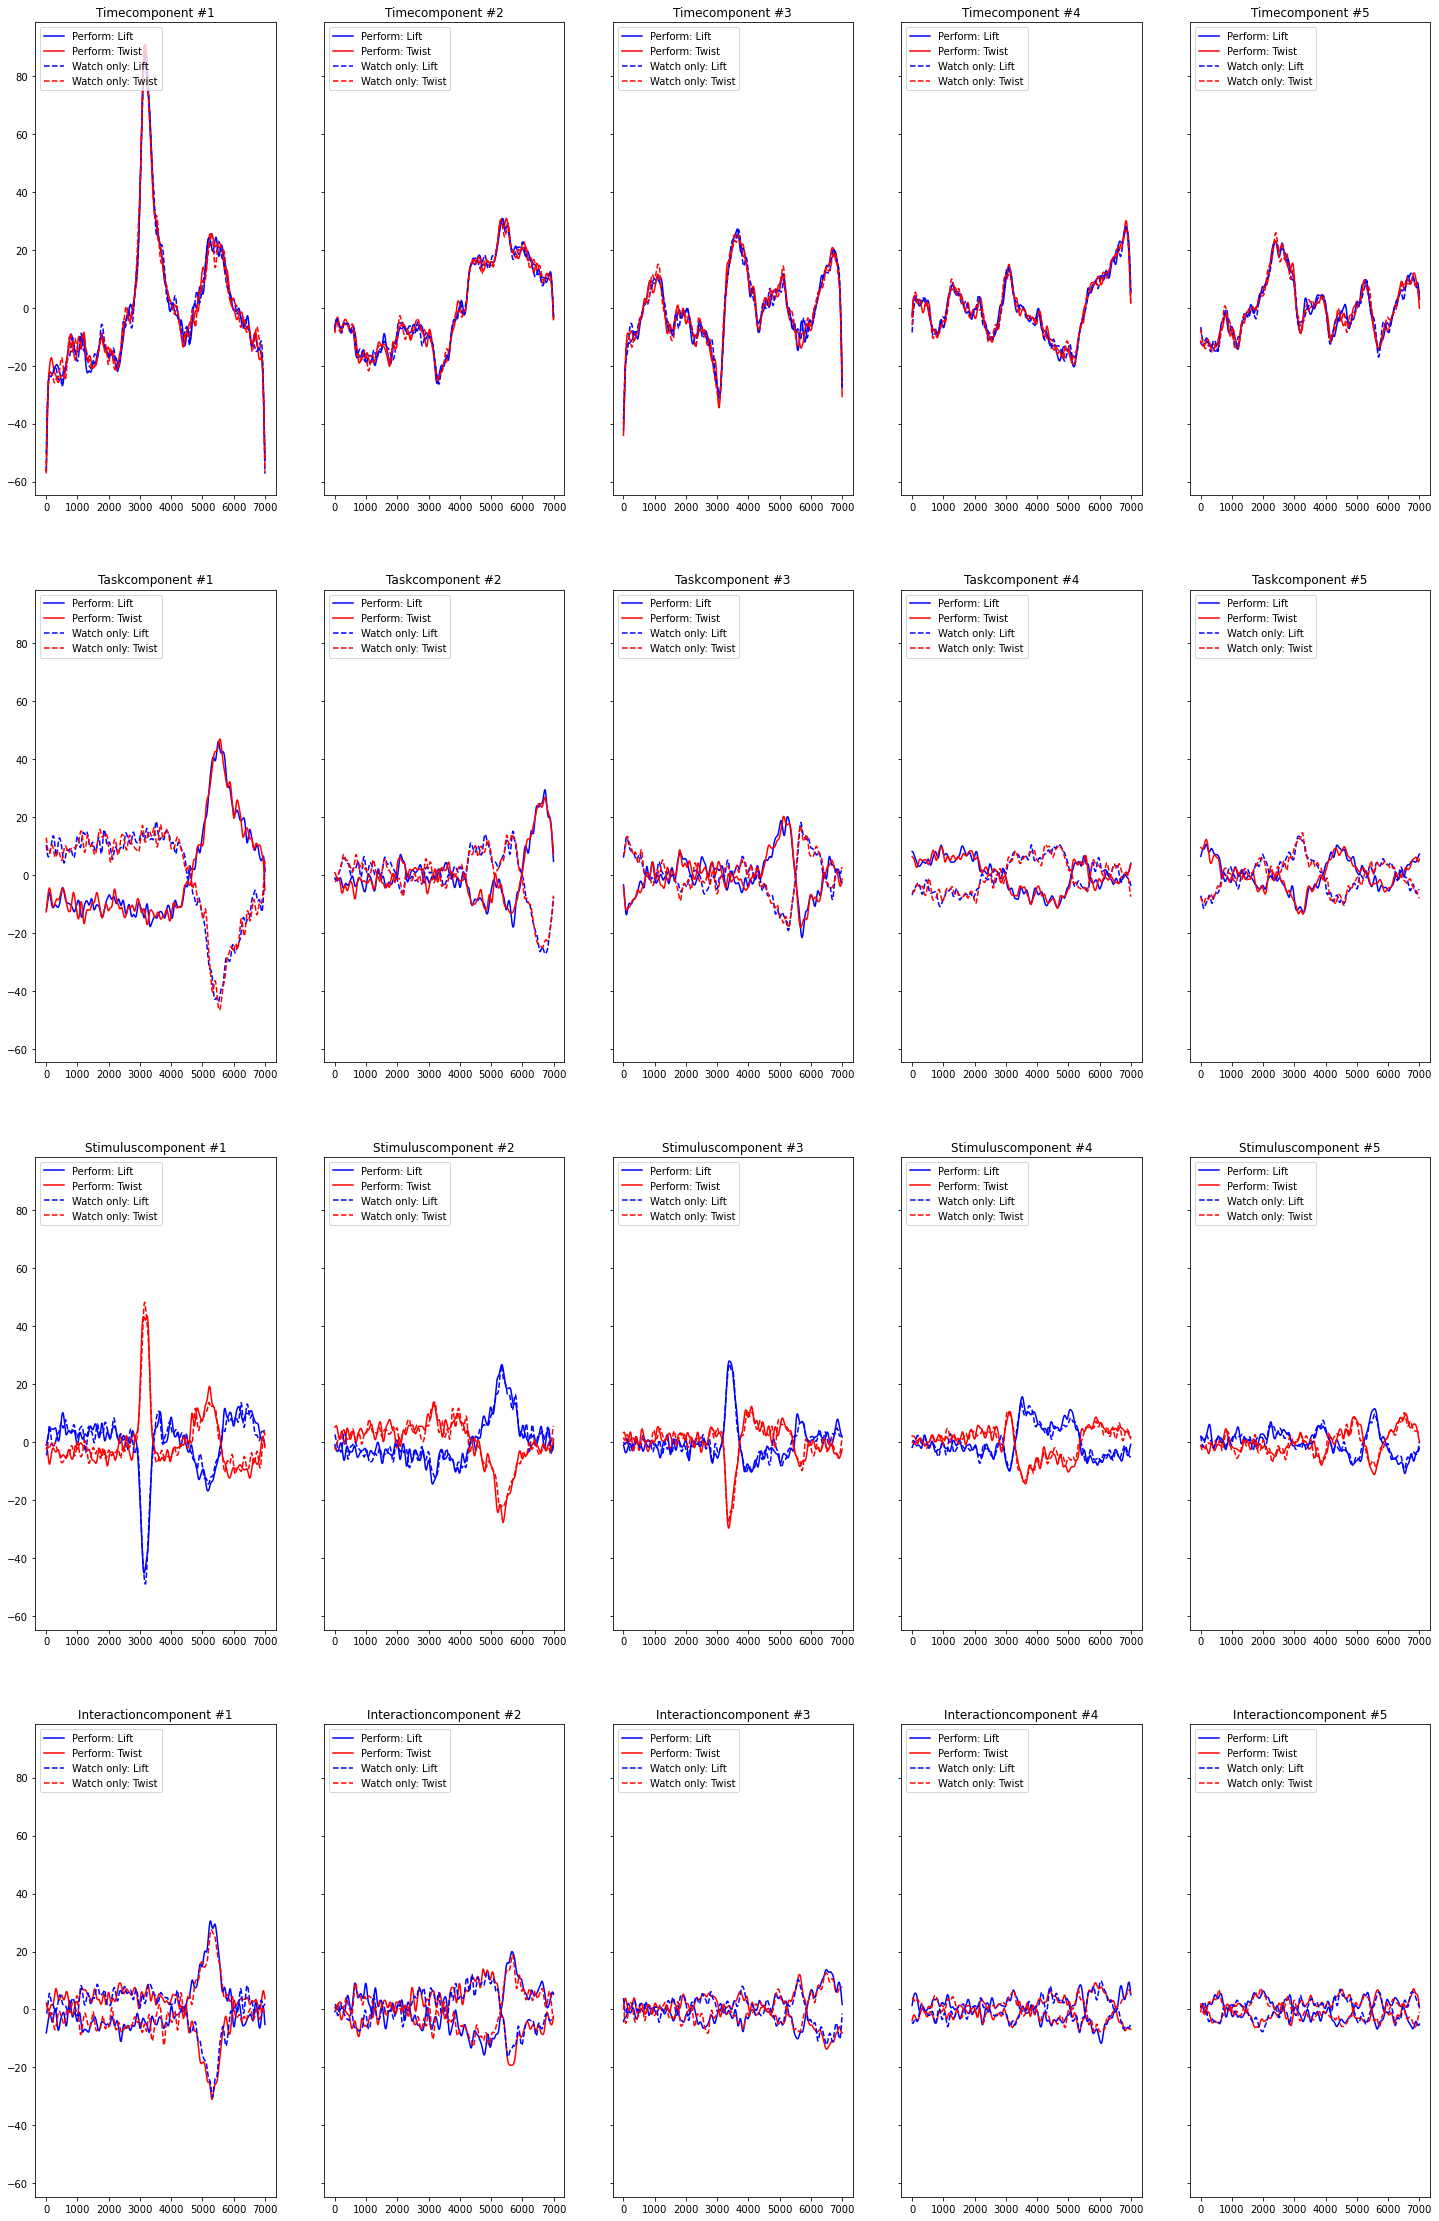

In [118]:
plot_dpca(Z)

##### Variance explained by components

In [125]:
for i in plot_dictionary:
    print("Variance Explained by the 1st dPCA "+plot_dictionary[i][1]+" component",dpca.explained_variance_ratio_[plot_dictionary[i][0]][0]*100,'%')

Variance Explained by the 1st dPCA Time component 18.896373846626485 %
Variance Explained by the 1st dPCA Task component 9.852453945212947 %
Variance Explained by the 1st dPCA Stimulus component 3.6315315807272297 %
Variance Explained by the 1st dPCA Interaction component 2.3965554030771936 %


## dPCA filtered data 

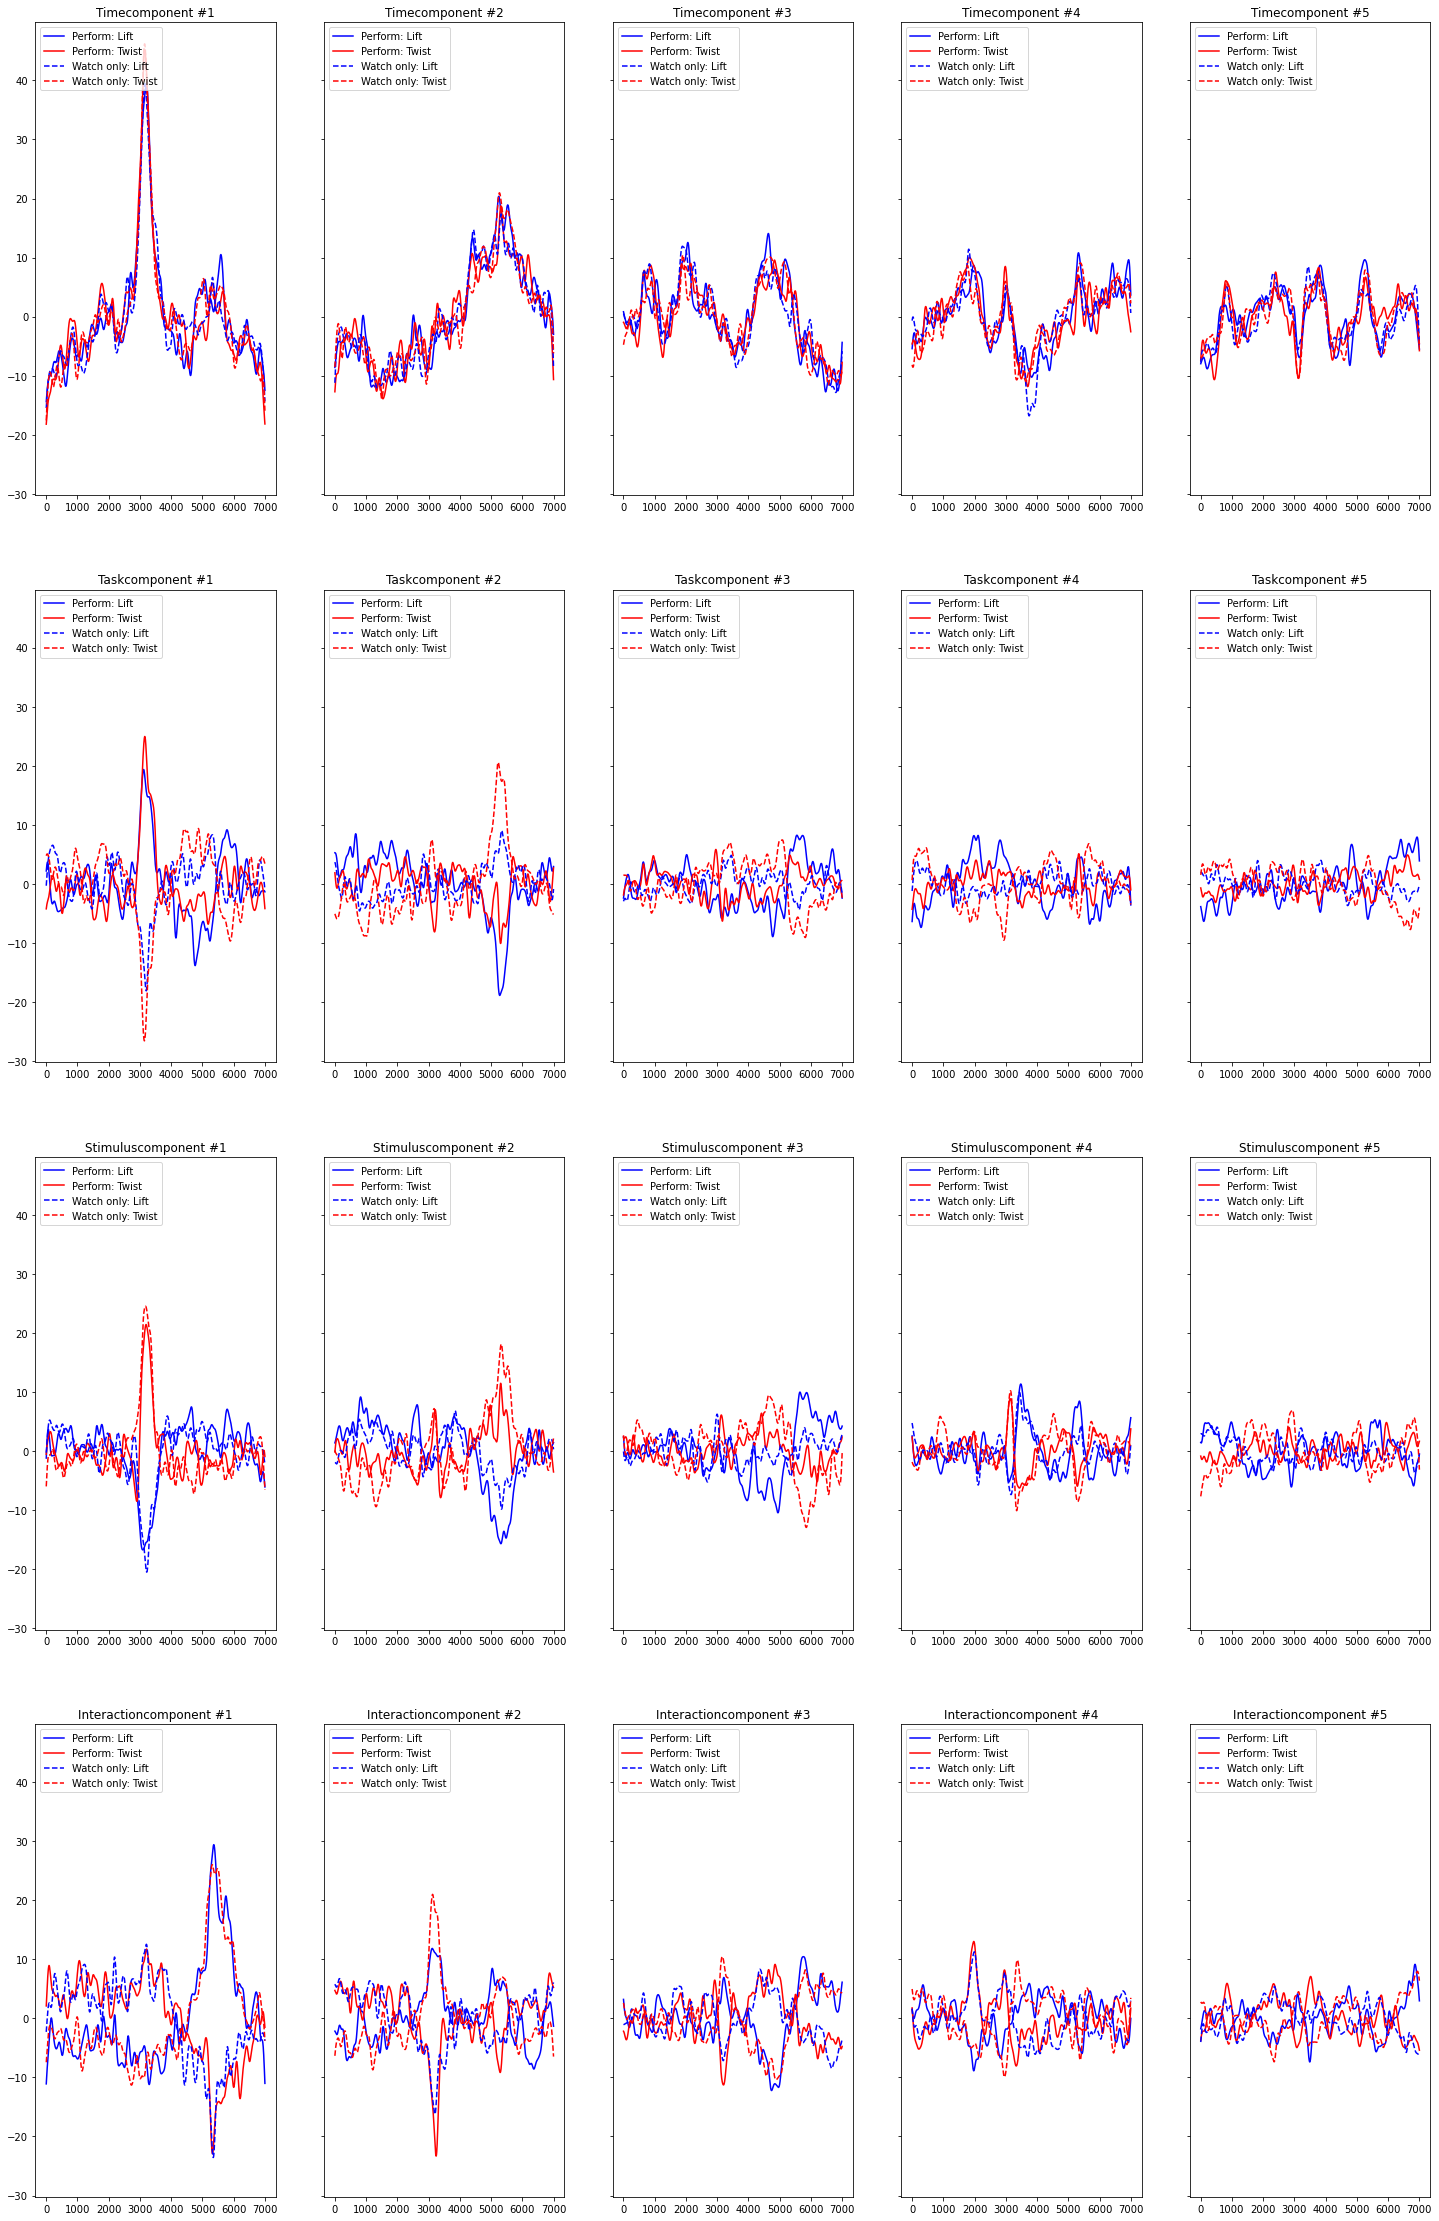

In [120]:
plot_dpca(Z_f)

#### Variance explained by components

In [127]:
for i in plot_dictionary:
    print("Variance Explained by the 1st dPCA "+plot_dictionary[i][1]+" component",dpca_f.explained_variance_ratio_[plot_dictionary[i][0]][0]*100,'%')

Variance Explained by the 1st dPCA Time component 11.119172401477254 %
Variance Explained by the 1st dPCA Task component 3.508228957725635 %
Variance Explained by the 1st dPCA Stimulus component 2.887322370565404 %
Variance Explained by the 1st dPCA Interaction component 7.266825783597926 %


# K-nearest neighbour classification of trials

# Constructing Per Neuron Trials Dataframes

In [3]:
#initializing  empty dataframe in nice format
cols=["Neuron","Condition","Task","Trial","Spike_train"]
trials_empty=pd.DataFrame(columns=cols)

In [30]:
trials_path='/Users/machraouianas/Desktop/MPI TU/code/data3/'
trials_files = [f for f in sorted(np.unique(os.listdir(trials_path))) if f[-1]=="v"]

for i in range(0,len(trials_files),4):




    trials_neuron=trials_empty
    for j in range(i,i+4):
        trials_temp=pd.read_csv(os.path.join(trials_path+trials_files[j]))
        trials_spike_train=[]
        for k in range(len(trials_temp)):
            df1=trials_temp.iloc[k,:]
      
            df1=df1.reset_index(drop=True)
            df1.index=df1.index+1
  
            df1.index=df1.index*0.002
            df1=df1[df1==1]
            trials_spike_train.append(neo.SpikeTrain(df1.index*s, t_start=0,t_stop=7, units='s'))

        
        trials_temp["Neuron"]=trials_files[j][:-4].split("t")[0][1:]
        trials_temp["Condition"]=trials_files[j][:-4].split("c")[1][0]
        trials_temp["Task"]=trials_files[j][:-4].split("t")[1][0]
        trials_temp["Trial"]=trials_temp.index
        trials_temp=trials_temp[["Neuron","Condition","Task","Trial"]]
        trials_temp=trials_temp.astype(int)
        trials_temp=trials_temp.sort_values(by=["Task"]).reset_index(drop=True)
        
        trials_temp["Spike_train"]=trials_spike_train
        
        trials_neuron=trials_neuron.append(trials_temp)
        
    
    
    trials_neuron.to_csv(path_or_buf="/Users/machraouianas/Desktop/MPI TU/code/data3/Neuron_trials/Neuron_spikes_"+str(trials_neuron.iloc[0,0]))


In [137]:
trials_neuron.dtypes

Neuron         object
Condition      object
Task           object
Trial          object
Spike_train    object
dtype: object

# Constructing distances matrix per Neuron 

In [98]:
from elephant.spike_train_dissimilarity import victor_purpura_distance

In [ ]:
#helper function to generate spike trains in elephant format
def generate_spikes(spikes):
    new_f=[]
    f=[f for f in spikes.split(" ") if ("." in f and len(f)>0)]
    f[0]=f[0].split("[")[1]
    f[-1]=f[-1].split("]")[0]
    for i in range(len(f)):
        if ("\n" in f[i]):
            f[i]=f[-1].split("\n")[0]
        f[i]=float(f[i])
    return  neo.SpikeTrain(f*s, t_start=0,t_stop=7, units='s')

In [79]:
trials_per_neuron_path='/Users/machraouianas/Desktop/MPI TU/code/data3/Neuron_trials'
trials_per_neuron_files=[f for f in os.listdir(trials_per_neuron_path) if f[0]=="N"]

In [232]:
for filename in trials_per_neuron_files:
  
  #loading each tuple
  neuron_spikes=pd.read_csv(os.path.join(trials_per_neuron_path,filename))
  VP_matrix = pd.DataFrame(0, index=neuron_spikes.index, columns=neuron_spikes.index)
  for i in range(len(VP_matrix)):
    for j in range(i):
        VP_matrix.iloc[i,j]=victor_purpura_distance(
                                                   [generate_spikes(neuron_spikes.iloc[i,-1]), 
                                                     generate_spikes(neuron_spikes.iloc[j,-1])]
                                                     )[0,1]
        VP_matrix.iloc[j,i]=VP_matrix.iloc[i,j]
  VP_matrix.to_csv(path_or_buf=trials_per_neuron_path+"/"+"Matrix"+str(neuron_spikes.iloc[0,1]))

In [496]:
VP_matrix

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,0.000,3.226,0.166,2.098,1.060,0.740,4.000,1.898,2.000,3.100,...,2.000,2.000,1.180,2.000,2.000,3.626,4.00,2.00,3.000,0.100
1,3.226,0.000,3.392,2.822,3.124,3.196,5.328,3.108,4.382,3.684,...,3.864,4.712,3.244,4.358,4.144,4.762,6.55,3.44,4.590,3.126
2,0.166,3.392,0.000,1.932,0.894,0.574,4.000,1.732,2.000,3.066,...,2.000,2.000,1.014,2.000,2.000,3.460,4.00,2.00,3.000,0.266
3,2.098,2.822,1.932,0.000,1.038,1.358,5.000,1.768,3.000,2.860,...,2.524,3.000,1.050,3.000,2.804,3.260,5.00,3.00,3.250,2.198
4,1.060,3.124,0.894,1.038,0.000,0.320,4.000,0.838,2.000,3.180,...,1.594,2.000,0.120,2.000,1.874,2.566,4.00,2.00,2.320,1.160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,3.626,4.762,3.460,3.260,2.566,2.886,4.852,2.272,2.226,4.252,...,2.208,2.104,2.446,3.766,2.072,0.000,2.49,4.00,1.562,3.726
64,4.000,6.550,4.000,5.000,4.000,4.000,4.712,3.442,2.168,5.366,...,2.686,2.004,4.000,3.626,2.406,2.490,0.00,4.00,2.140,4.000
65,2.000,3.440,2.000,3.000,2.000,2.000,2.066,2.000,2.000,5.000,...,2.000,2.000,2.000,0.918,2.000,4.000,4.00,0.00,3.000,2.000
66,3.000,4.590,3.000,3.250,2.320,2.640,3.932,1.482,1.146,4.086,...,1.274,1.184,2.200,2.846,1.384,1.562,2.14,3.00,0.000,3.000


In [497]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [498]:
VP_matrix

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,0.000,3.226,0.166,2.098,1.060,0.740,4.000,1.898,2.000,3.100,...,2.000,2.000,1.180,2.000,2.000,3.626,4.00,2.00,3.000,0.100
1,3.226,0.000,3.392,2.822,3.124,3.196,5.328,3.108,4.382,3.684,...,3.864,4.712,3.244,4.358,4.144,4.762,6.55,3.44,4.590,3.126
2,0.166,3.392,0.000,1.932,0.894,0.574,4.000,1.732,2.000,3.066,...,2.000,2.000,1.014,2.000,2.000,3.460,4.00,2.00,3.000,0.266
3,2.098,2.822,1.932,0.000,1.038,1.358,5.000,1.768,3.000,2.860,...,2.524,3.000,1.050,3.000,2.804,3.260,5.00,3.00,3.250,2.198
4,1.060,3.124,0.894,1.038,0.000,0.320,4.000,0.838,2.000,3.180,...,1.594,2.000,0.120,2.000,1.874,2.566,4.00,2.00,2.320,1.160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,3.626,4.762,3.460,3.260,2.566,2.886,4.852,2.272,2.226,4.252,...,2.208,2.104,2.446,3.766,2.072,0.000,2.49,4.00,1.562,3.726
64,4.000,6.550,4.000,5.000,4.000,4.000,4.712,3.442,2.168,5.366,...,2.686,2.004,4.000,3.626,2.406,2.490,0.00,4.00,2.140,4.000
65,2.000,3.440,2.000,3.000,2.000,2.000,2.066,2.000,2.000,5.000,...,2.000,2.000,2.000,0.918,2.000,4.000,4.00,0.00,3.000,2.000
66,3.000,4.590,3.000,3.250,2.320,2.640,3.932,1.482,1.146,4.086,...,1.274,1.184,2.200,2.846,1.384,1.562,2.14,3.00,0.000,3.000


In [238]:
y_labels=neuron_spikes["Task"]

In [241]:
trials_per_neuron_path='/Users/machraouianas/Desktop/MPI TU/code/data3/Neuron_trials'


187

In [694]:
Y_lift.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 61, 62, 63, 64, 65, 66, 67, 68, 69,
            70, 71, 72, 73, 74],
           dtype='int64')

In [709]:
accuracy_lift=[]
accuracy_twist=[]

for k in range(1,len(trials_per_neuron_files)+1):
    trials_matrix=pd.read_csv(os.path.join(trials_per_neuron_path+"/Neuron_spikes_"+str(k)))
    distance_matrix=pd.read_csv(os.path.join(trials_per_neuron_path+"/Matrix"+str(k)))
    X=distance_matrix.iloc[:,1:]
    
    Y_lift=trials_matrix[trials_matrix["Condition"]==1]["Task"]
    Y_twist=trials_matrix[trials_matrix["Condition"]==2]["Task"]
    
    Y_lift_test=[]
    Y_twist_test=[]
    #for lift trials
    
    for  j in Y_lift.index:
        dist_row=X.iloc[Y_lift.index,j]
        dist_df=pd.DataFrame(dist_row,index=dist_row.index,columns=["distance"])
        dist_df["distance"]=dist_row
        dist_df["trial"]=Y_lift
        dist_df=dist_df.sort_values(by="distance",ascending="True")
        dist_df=dist_df[1:4]
        Y_lift_test.append(np.bincount(dist_df["trial"]).argmax())
    accuracy_lift.append(accuracy_score(Y_lift, Y_lift_test))
    
    
    #for twist trials
    
    for  i in Y_twist.index:
        dist_row=X.iloc[Y_twist.index,i]
        dist_df=pd.DataFrame(dist_row,index=dist_row.index,columns=["distance"])
        dist_df["distance"]=dist_row
        dist_df["trial"]=Y_twist
        dist_df=dist_df.sort_values(by="distance",ascending="True")
        dist_df=dist_df[1:4]
        Y_twist_test.append(np.bincount(dist_df["trial"]).argmax())
    accuracy_twist.append(accuracy_score(Y_twist, Y_twist_test)) 
    

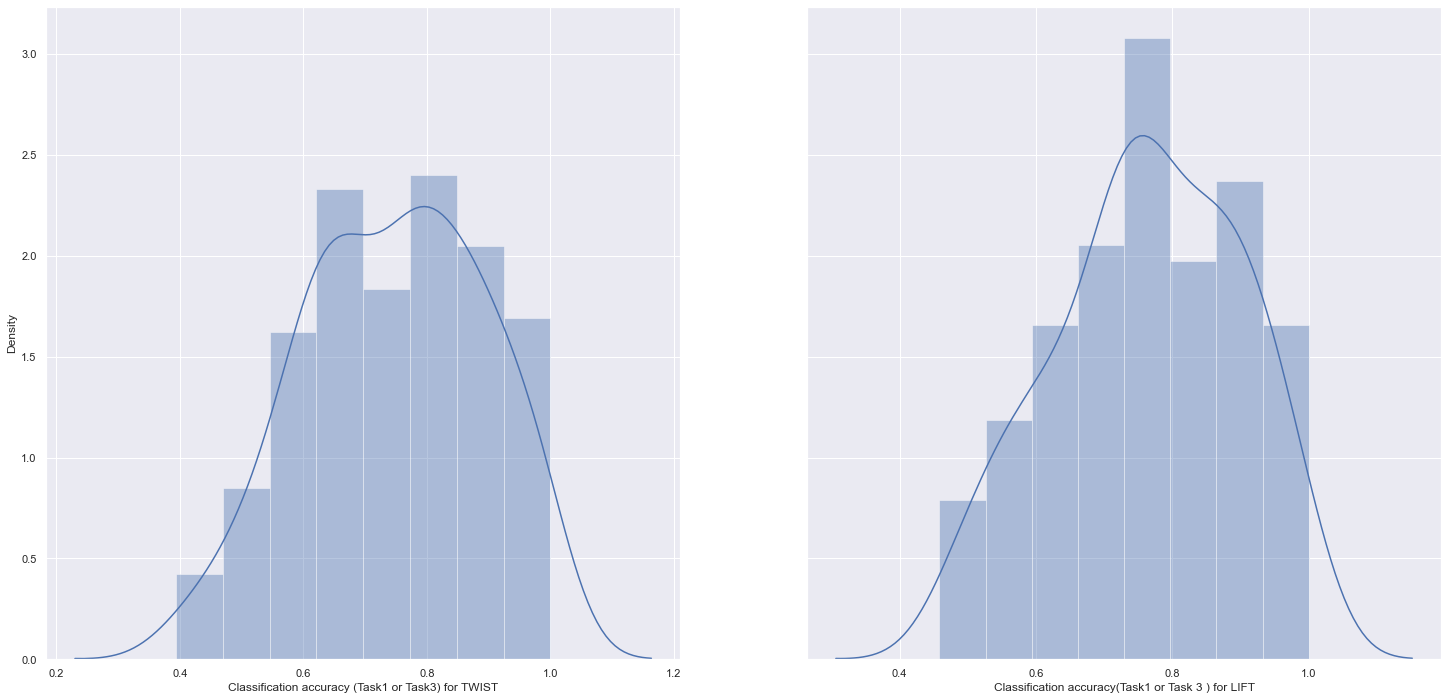

In [710]:
f, axs = plt.subplots(1, 2, sharey=True,figsize=(25,12))
accuracy_twist = pd.Series(accuracy_twist, name="Classification accuracy (Task1 or Task3) for TWIST")
accuracy_lift=pd.Series(accuracy_lift, name="Classification accuracy(Task1 or Task 3 ) for LIFT")
sns.distplot(accuracy_twist,ax=axs[0])
sns.distplot(accuracy_lift,ax=axs[1])
axs[0].set_ylabel("Density")


plt.show()

f.savefig("histograms_classification")

### Kruskal Wallis test for accuracy distribution 

In [979]:
scipy.stats.kruskal(accuracy_twist,accuracy_lift)

KruskalResult(statistic=1.062512016981344, pvalue=0.3026429506349574)

In [1095]:
top_lift_acc=pd.DataFrame(accuracy_lift,index=accuracy_lift.index).sort_values(by="Classification accuracy(Task1 or Task 3 ) for LIFT",ascending=False)[0:10].index
top_twist_acc=pd.DataFrame(accuracy_twist,index=accuracy_twist.index).sort_values(by="Classification accuracy (Task1 or Task3) for TWIST",ascending=False)[0:10].index

In [1096]:
top_lift_acc

Int64Index([66, 24, 126, 22, 184, 43, 117, 132, 92, 109], dtype='int64')

In [1097]:
top_twist_acc

Int64Index([66, 184, 108, 105, 162, 133, 43, 107, 132, 158], dtype='int64')

## Raster plots for similar Neurons

In [1098]:
data_path="/Users/machraouianas/Desktop/MPI TU/code/data3/"
experiment3_files = [f for f in os.listdir(data_path) if (("t3" in f) or ("t1" in f))]
n66_1=pd.read_csv(data_path+"n66t1c1.csv")
n66_2=pd.read_csv(data_path+"n66t3c1.csv")
n66_3=pd.read_csv(data_path+"n66t1c2.csv")
n66_4=pd.read_csv(data_path+"n66t3c2.csv")

In [1099]:
events=[]
neuron66_trials=[n66_1,n66_2,n66_3,n66_4]
for idx in range(len(neuron66_trials)):
    events_temp=[]
    for index,trial in neuron66_trials[idx].iterrows():
        trial=trial.reset_index(drop=True)
        events_temp.append(list(trial[trial>0].index*0.002))
    events.append(events_temp)

Text(0.5, 0, 'TASK 1 vs TASK 1,Li vs Tw')

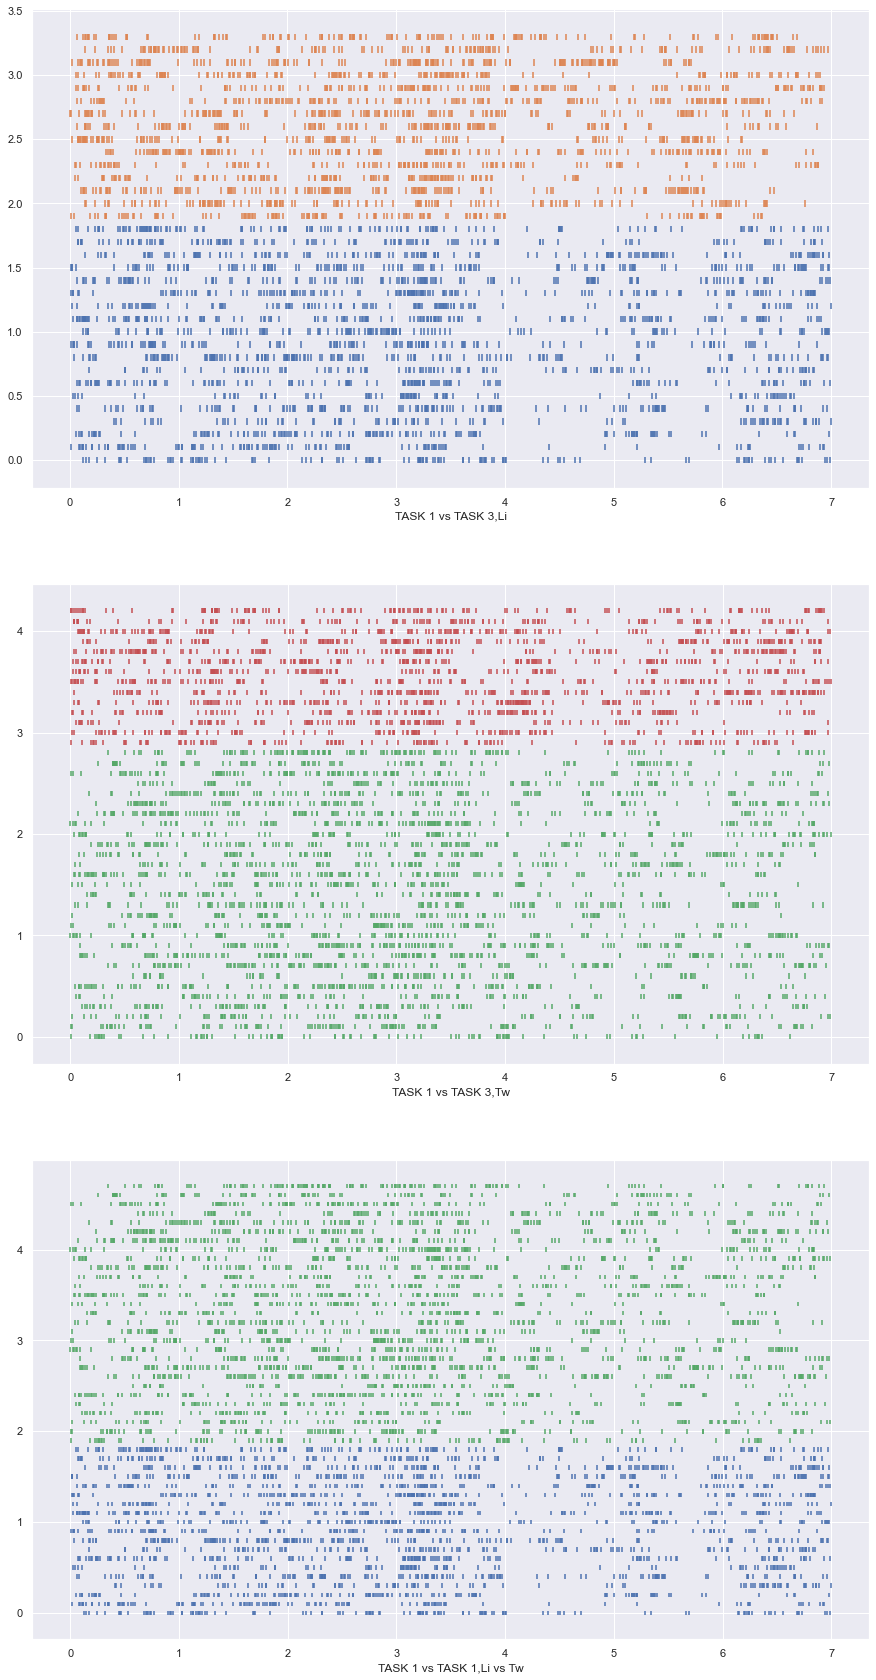

In [1100]:
fig, axs = plt.subplots(3,1,figsize=(15,30))

colors0=np.repeat("C0",len(events[0]))
colors1=np.repeat("C1",len(events[1]))
colors2=np.repeat("C2",len(events[2]))
colors3=np.repeat("C3",len(events[3]))

axs[0].eventplot(np.concatenate((events[0],events[1])), colors=np.concatenate((colors0,colors1)), lineoffsets=0.1,
                    linelengths=0.05)
axs[0].set_xlabel("TASK 1 vs TASK 3,Li")

axs[1].eventplot(np.concatenate((events[2],events[3])), colors=np.concatenate((colors2,colors3)), lineoffsets=0.1,
                    linelengths=0.05)
axs[1].set_xlabel("TASK 1 vs TASK 3,Tw")


axs[2].eventplot(np.concatenate((events[0],events[2])), colors=np.concatenate((colors0,colors2)), lineoffsets=0.1,
                    linelengths=0.05)
axs[2].set_xlabel("TASK 1 vs TASK 1,Li vs Tw")

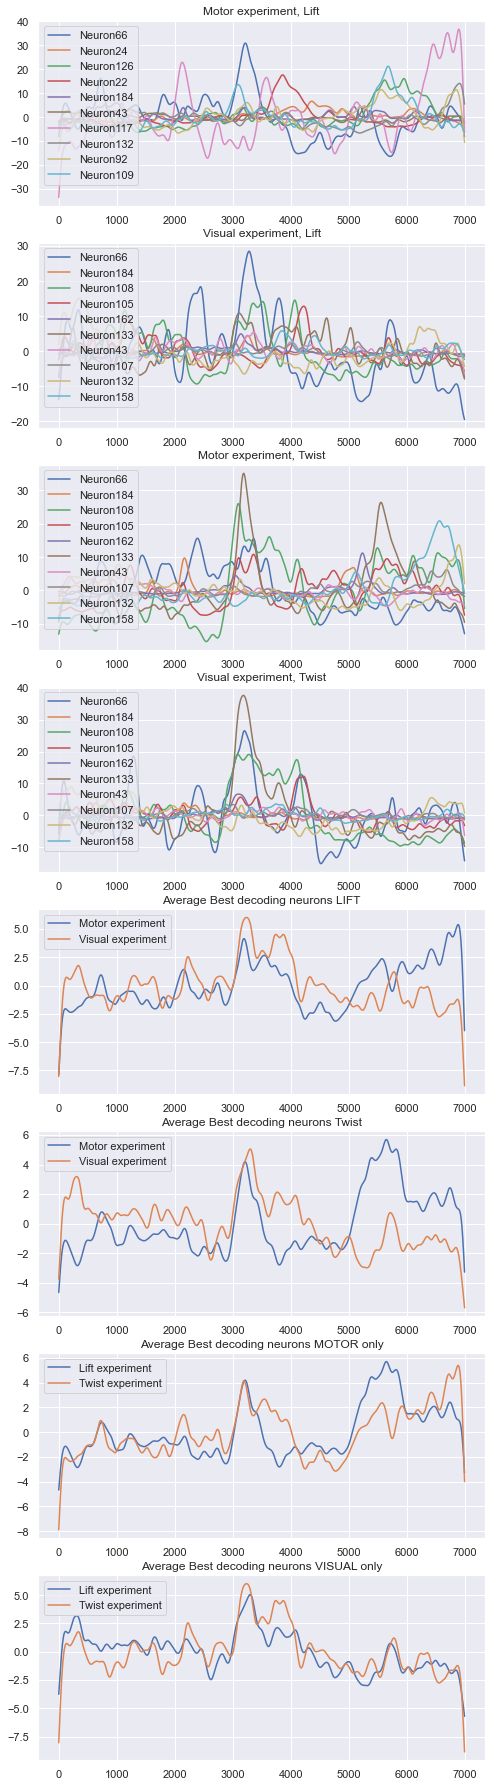

In [1105]:
psth_path="/Users/machraouianas/Desktop/MPI TU/code/data3/psth_raw/"
f,axs = plt.subplots(8,1,figsize=(8,32))
for n in top_lift_acc:
    axs[0].plot(np.load(psth_path+"n{}t1c1.npy".format(n)),label="Neuron{}".format(n))
    axs[0].legend(loc='upper left')
    axs[0].set_title("Motor experiment, Lift")
for n in top_twist_acc:
    axs[1].plot(np.load(psth_path+"n{}t3c1.npy".format(n)),label="Neuron{}".format(n))
    axs[1].legend(loc='upper left')
    axs[1].set_title("Visual experiment, Lift")    
    
for n in top_twist_acc:
    axs[2].plot(np.load(psth_path+"n{}t1c2.npy".format(n)),label="Neuron{}".format(n))
    axs[2].legend(loc='upper left')
    axs[2].set_title("Motor experiment, Twist") 
    
for n in top_twist_acc:
    axs[3].plot(np.load(psth_path+"n{}t3c2.npy".format(n)),label="Neuron{}".format(n))
    axs[3].legend(loc='upper left')
    axs[3].set_title("Visual experiment, Twist") 
 
axs[4].plot(top_motor_lift,label="Motor experiment")
axs[4].legend(loc='upper left')

axs[4].plot(top_visual_lift,label="Visual experiment")
axs[4].legend(loc='upper left')

axs[4].set_title("Average Best decoding neurons LIFT") 


axs[5].plot(top_motor_twist,label="Motor experiment")
axs[5].legend(loc='upper left')

axs[5].plot(top_visual_twist,label="Visual experiment")
axs[5].legend(loc='upper left')

axs[5].set_title("Average Best decoding neurons Twist") 

axs[6].plot(top_motor_twist,label="Lift experiment")
axs[6].legend(loc='upper left')

axs[6].plot(top_motor_lift,label="Twist experiment")
axs[6].legend(loc='upper left')

axs[6].set_title("Average Best decoding neurons MOTOR only")

axs[7].plot(top_visual_twist,label="Lift experiment")
axs[7].legend(loc='upper left')

axs[7].plot(top_visual_lift,label="Twist experiment")
axs[7].legend(loc='upper left')

axs[7].set_title("Average Best decoding neurons VISUAL only")



plt.show()
    

In [1104]:
top_motor_lift=np.zeros((7000,1))
top_visual_lift=np.zeros((7000,1))

top_motor_twist=np.zeros((7000,1))
top_visual_twist=np.zeros((7000,1))
psth_path="/Users/machraouianas/Desktop/MPI TU/code/data3/psth_raw/"

for n in top_lift_acc:
    top_motor_lift+=np.load(psth_path+"n{}t1c1.npy".format(n))
    top_visual_lift+=np.load(psth_path+"n{}t3c1.npy".format(n))
top_motor_lift/=10
top_visual_lift/=10
                             
for n in top_twist_acc:
    top_motor_twist+=np.load(psth_path+"n{}t1c1.npy".format(n))
    top_visual_twist+=np.load(psth_path+"n{}t3c1.npy".format(n))

top_motor_twist/=10
top_visual_twist/=10

In [1103]:
a=np.load(psth_path+"n{}t1c2.npy".format("66"))

In [1079]:
np.shape(a)

(7000, 1)